In [113]:
# imported necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from scipy.stats import uniform
import warnings
import graphviz
from sklearn.tree import export_graphviz

In [114]:
warnings.filterwarnings("ignore")

In [115]:
import sqlite3
con = sqlite3.connect("final.sqlite")

In [116]:
cleaned_data = pd.read_sql_query("select * from Reviews", con)

In [117]:
cleaned_data.shape

(364171, 12)

In [118]:
# Sort data based on time
cleaned_data["Time"] = pd.to_datetime(cleaned_data["Time"], unit = "s")
cleaned_data = cleaned_data.sort_values(by = "Time")
#cleaned_data.head()

In [119]:
cleaned_data["Score"].value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

In [121]:
final = cleaned_data.iloc[:100000,:]
final.shape

(100000, 12)

In [122]:
# converting scores in 0 and 1
final["Score"] = final["Score"].apply(lambda x: 1 if x == "positive" else 0)


# Bag of Word

In [123]:
def optimal_tree_xgb(X_train, y_train):
    
    param = {"max_depth": list(range(3, 20, 3)), "n_estimators": list(range(3, 20, 3))}
    cv = TimeSeriesSplit(n_splits = 3)
    xgb_grid = GridSearchCV(XGBClassifier(), param_grid = param, cv = cv, scoring = "roc_auc")
    xgb_grid.fit(X_train, y_train)
    print("\n**********GridSearchCV**********\n")
    print("\nBest depth:", xgb_grid.best_estimator_.max_depth)
    print("\nBest estimator:", xgb_grid.best_estimator_.n_estimators)
    print("\nBest Score:", xgb_grid.best_score_)
    
    # https://towardsdatascience.com/using-3d-visualizations-to-tune-hyperparameters-of-ml-models-with-python-ba2885eab2e9s
    df_gridsearch = pd.DataFrame(xgb_grid.cv_results_)
    max_scores = df_gridsearch.groupby(['param_max_depth','param_n_estimators']).max()
    max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
    sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g')
    plt.show()
    return xgb_grid.best_estimator_.max_depth, xgb_grid.best_estimator_.n_estimators

In [124]:
def optimal_tree_rf(X_train, y_train):
    
    param = {"max_depth": list(range(3, 20 ,3)), "n_estimators": list(range(3, 20, 3))}
    cv = TimeSeriesSplit(n_splits = 3)
    rf_grid = GridSearchCV(RandomForestClassifier(), param_grid = param, cv = cv, scoring = "roc_auc")
    rf_grid.fit(X_train, y_train)
    print("\n**********GridSearchCV**********\n")
    print("\nBest depth:", rf_grid.best_estimator_.max_depth)
    print("\nBest estimator:", rf_grid.best_estimator_.n_estimators)
    print("\nBest Score:", rf_grid.best_score_)
    
    df_gridsearch = pd.DataFrame(rf_grid.cv_results_)
    max_scores = df_gridsearch.groupby(['param_max_depth','param_n_estimators']).max()
    max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
    sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g')
    plt.show()
    return rf_grid.best_estimator_.max_depth, rf_grid.best_estimator_.n_estimators

In [131]:
# 100k data which will use to train model after vectorization
X = final["CleanedText"]
print("shape of X:", X.shape)

shape of X: (100000,)


In [132]:
# class label
y = final["Score"]
print("shape of y:", y.shape)

shape of y: (100000,)


In [133]:
# split data into train and test where 70% data used to train model and 30% for test
from sklearn.model_selection import train_test_split
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print(X_train.shape, y_train.shape, x_test.shape)

(70000,) (70000,) (30000,)


In [134]:
# Train Vectorizor
from sklearn.feature_extraction.text import CountVectorizer

bow = CountVectorizer()
X_train = bow.fit_transform(X_train)
X_train

<70000x31419 sparse matrix of type '<class 'numpy.int64'>'
	with 2104282 stored elements in Compressed Sparse Row format>

In [135]:
# Test Vectorizor
x_test = bow.transform(x_test)
x_test

<30000x31419 sparse matrix of type '<class 'numpy.int64'>'
	with 903932 stored elements in Compressed Sparse Row format>


**********GridSearchCV**********


Best depth: 18

Best estimator: 18

Best Score: 0.8498340602591153


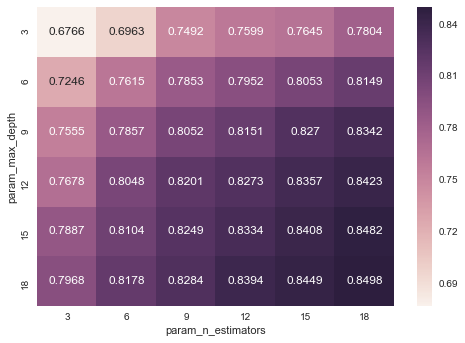

In [136]:
# XGBoost
optimal_max_depth_bow, optimal_n_estimators_bow = optimal_tree_xgb(X_train, y_train)

In [141]:
# instantiate learning model max_depth = max_depth_bow
clf = XGBClassifier(max_depth = optimal_max_depth_bow, n_estimators = optimal_n_estimators_bow)
# fitting the model
clf.fit(X_train, y_train)
# predict the response
pred = clf.predict(x_test)
# predict probablistic response
pred_prob = clf.predict_proba(x_test)

In [142]:
train_acc_bow = clf.score(X_train, y_train)
print("Train accuracy:",train_acc_bow)

Train accuracy: 0.9209


In [143]:
test_acc_bow = roc_auc_score(y_test, pred_prob[:,1]) * 100
print('\nThe test accuracy is %.2f%%' % (test_acc_bow))


The test accuracy is 85.30%


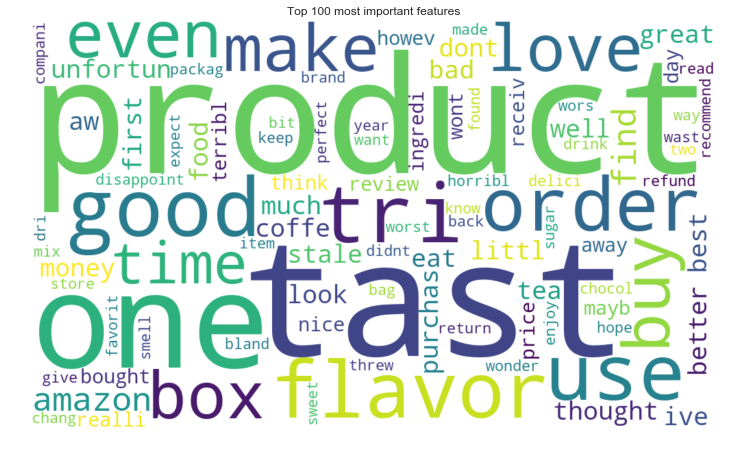

In [144]:
from wordcloud import WordCloud, STOPWORDS

features = bow.get_feature_names()
coef = clf.feature_importances_
coef_df = pd.DataFrame({'word': features, 'coeficient': coef}, index = None)
df = coef_df.sort_values("coeficient", ascending = False)[:100]
cloud = " ".join(word for word in df.word)
stopwords = set(STOPWORDS) 
wordcloud = WordCloud(width = 1000, height = 600, background_color ='white', stopwords = stopwords).generate(cloud) 
  
# plot the WordCloud image                        
plt.figure(figsize = (10, 8)) 
plt.imshow(wordcloud, interpolation = 'bilinear') 
plt.axis("off") 
plt.title("Top 100 most important features")
plt.tight_layout(pad = 0) 
  
plt.show() 

In [145]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[  819,  2798],
       [  228, 26155]], dtype=int64)

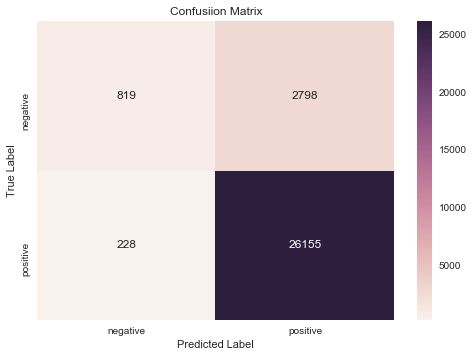

In [146]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [147]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.78      0.23      0.35      3617
           1       0.90      0.99      0.95     26383

   micro avg       0.90      0.90      0.90     30000
   macro avg       0.84      0.61      0.65     30000
weighted avg       0.89      0.90      0.87     30000



**Observations**<br>
1. Applied xgboost and it works quite well on test data. 
2. We can see in heatmap, when the maximum depth and number of estimator is 18, roc_auc score is good. I.e. It is the best estimator. 
3. Generated wordcloud of top 100 most important features where we can see which feature is most important.


**********GridSearchCV**********


Best depth: 15

Best estimator: 18

Best Score: 0.8347906206380171


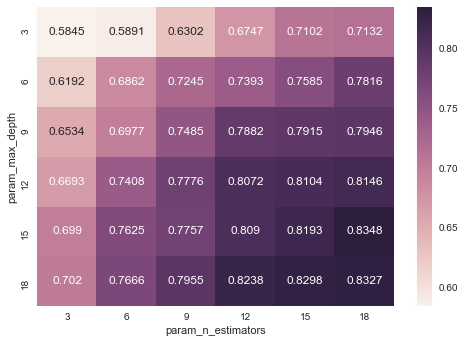

In [148]:
# Random Forest
optimal_max_depth_bow_rf, optimal_n_estimators_bow_rf = optimal_tree_rf(X_train, y_train)

In [149]:
# instantiate learning model max_depth = max_depth_bow
clf = RandomForestClassifier(max_depth = optimal_max_depth_bow_rf, n_estimators = optimal_n_estimators_bow_rf, class_weight = "balanced")
# fitting the model
clf.fit(X_train, y_train)
# predict the response
pred = clf.predict(x_test)
# predict probablistic response
pred_prob = clf.predict_proba(x_test)

In [150]:
train_acc_bow_rf = clf.score(X_train, y_train)
print("Train accuracy:",train_acc_bow_rf)

Train accuracy: 0.8602285714285715


In [151]:
test_acc_bow_rf = roc_auc_score(y_test, pred_prob[:,1]) * 100
print('\nThe test accuracy is %.2f%%' % (test_acc_bow_rf))


The test accuracy is 85.97%


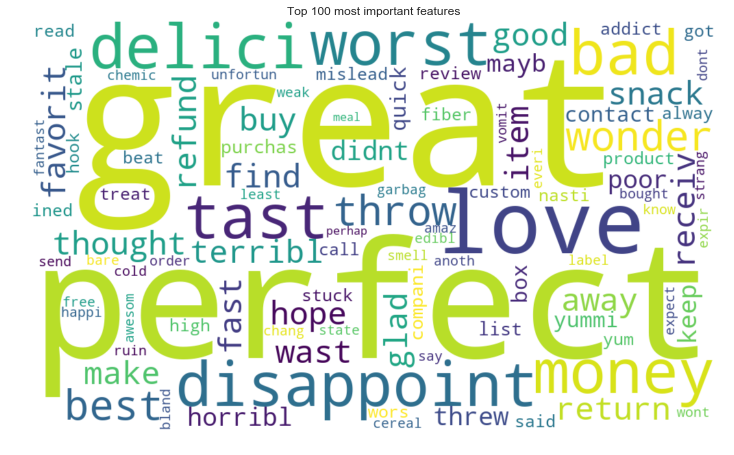

In [152]:
from wordcloud import WordCloud, STOPWORDS

features = bow.get_feature_names()
coef = clf.feature_importances_
coef_df = pd.DataFrame({'word': features, 'coeficient': coef}, index = None)
df = coef_df.sort_values("coeficient", ascending = False)[:100]
cloud = " ".join(word for word in df.word)
stopwords = set(STOPWORDS) 
wordcloud = WordCloud(width = 1000, height = 600, background_color ='white', stopwords = stopwords).generate(cloud) 
  
# plot the WordCloud image                        
plt.figure(figsize = (10, 8)) 
plt.imshow(wordcloud, interpolation = 'bilinear') 
plt.axis("off") 
plt.title("Top 100 most important features")
plt.tight_layout(pad = 0) 
  
plt.show() 

In [153]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[ 2470,  1147],
       [ 3655, 22728]], dtype=int64)

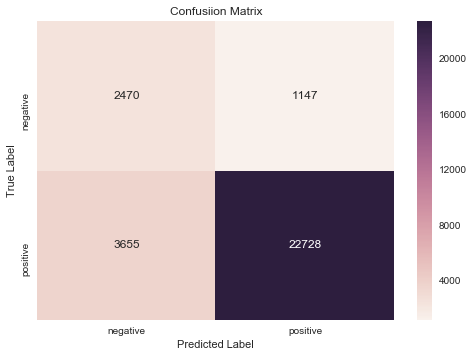

In [154]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [155]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.40      0.68      0.51      3617
           1       0.95      0.86      0.90     26383

   micro avg       0.84      0.84      0.84     30000
   macro avg       0.68      0.77      0.71     30000
weighted avg       0.89      0.84      0.86     30000



**Observations**</br>
1. Applied RandomForest and the hyperparameter, max_depth and n_estimator is 15 and 18 respectively.  
2. If we compare the results then random forest is slightly better than xgboost in bow.
3. When tested model on unseen data(test data) the auc score is 86%.In a nutshell we can say the generalization error is low means this model works well with unseen data.

# Tf-Idf

In [162]:
# data
X = final["CleanedText"]

In [163]:
# Target/class-label
y = final["Score"]

In [164]:
# Split data
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, shuffle = False)
print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

(70000,) (30000,) (70000,) (30000,)


In [165]:
from sklearn.feature_extraction.text import TfidfVectorizer

#tfidf = TfidfVectorizer()
#tfidf_data = tfidf.fit_transform(final_4000["CleanedText"])
#tfidf_data
tf_idf_vect = TfidfVectorizer()
X_train = tf_idf_vect.fit_transform(X_train)
X_trn = X_train
X_train

<70000x31373 sparse matrix of type '<class 'numpy.float64'>'
	with 2094656 stored elements in Compressed Sparse Row format>

In [166]:
# Convert test text data to its vectorizor
x_test = tf_idf_vect.transform(x_test)
x_tst = x_test
x_test.shape

(30000, 31373)


**********GridSearchCV**********


Best depth: 18

Best estimator: 18

Best Score: 0.843659562064826


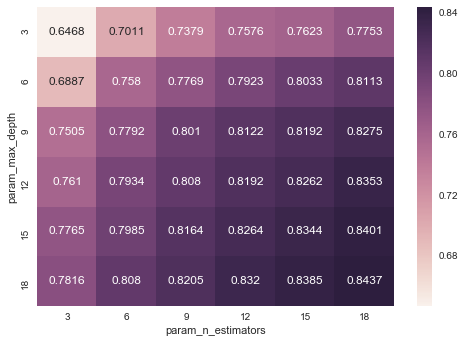

In [168]:
# XGBoost
optimal_max_depth_tfidf, optimal_n_estimators_tfidf = optimal_tree_xgb(X_train, y_train)

In [169]:
# instantiate learning model max_depth = mas_depth_tfidf
clf = XGBClassifier(max_depth = optimal_max_depth_tfidf, n_estimators = optimal_n_estimators_tfidf)
# fitting the model
clf.fit(X_train, y_train)
# predict the response
pred = clf.predict(x_test)
# predict probablistic response
pred_prob = clf.predict_proba(x_test)

In [171]:
train_acc_tfidf = clf.score(X_train, y_train)
print("Train accuracy %f%%:" % (train_acc_tfidf))

Train accuracy 0.924614%:


In [173]:
test_acc_tfidf = roc_auc_score(y_test, pred_prob[:,1]) * 100
print('\nThe accuracy of the decision tree is %.2f%%' % (test_acc_tfidf))


The accuracy of the decision tree is 86.01%


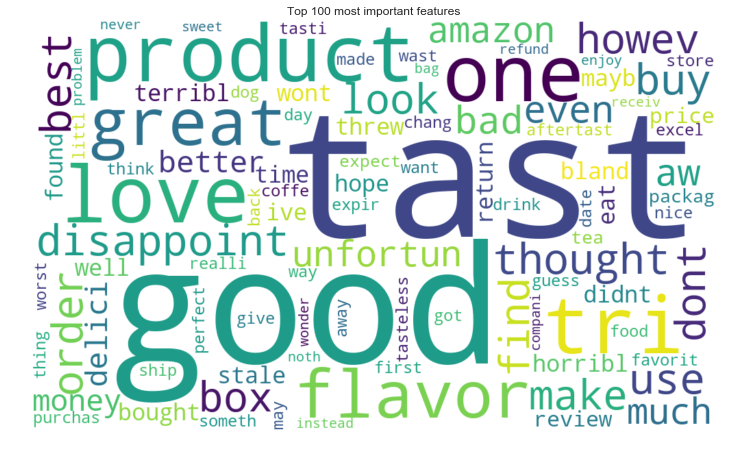

In [174]:
from wordcloud import WordCloud, STOPWORDS

features = tf_idf_vect.get_feature_names()
coef = clf.feature_importances_
coef_df = pd.DataFrame({'word': features, 'coeficient': coef}, index = None)
df = coef_df.sort_values("coeficient", ascending = False)[:100]
cloud = " ".join(word for word in df.word)
stopwords = set(STOPWORDS) 
wordcloud = WordCloud(width = 1000, height = 600, background_color ='white', stopwords = stopwords).generate(cloud) 
  
# plot the WordCloud image                        
plt.figure(figsize = (10, 8)) 
plt.imshow(wordcloud, interpolation = 'bilinear') 
plt.axis("off") 
plt.title("Top 100 most important features")
plt.tight_layout(pad = 0) 
  
plt.show() 

In [175]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[  913,  3190],
       [  204, 25693]], dtype=int64)

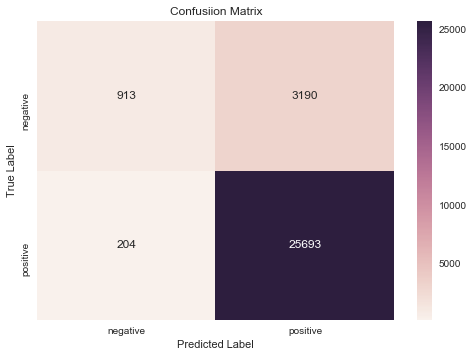

In [176]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [177]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.82      0.22      0.35      4103
           1       0.89      0.99      0.94     25897

   micro avg       0.89      0.89      0.89     30000
   macro avg       0.85      0.61      0.64     30000
weighted avg       0.88      0.89      0.86     30000



**Observations**<br> 
1. When the max_depth and n_estimator is 18 then the validataion score is high, so choosen as the best hyperparameter. 
2. There could be a chance that model is overfitting as the train error is slightly higher than test error.


**********GridSearchCV**********


Best depth: 15

Best estimator: 18

Best Score: 0.8218678049661128


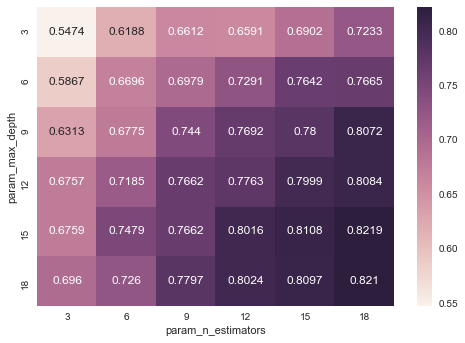

In [178]:
# Random forest
optimal_max_depth_tfidf_rf, optimal_n_estimators_tfidf_rf = optimal_tree_rf(X_train, y_train)

In [179]:
# instantiate learning model max_depth = max_depth_bow
clf = RandomForestClassifier(max_depth = optimal_max_depth_tfidf_rf, n_estimators = optimal_n_estimators_tfidf_rf, class_weight = "balanced")
# fitting the model
clf.fit(X_train, y_train)
# predict the response
pred = clf.predict(x_test)
# predict probablistic response
pred_prob = clf.predict_proba(x_test)

In [181]:
train_acc_tfidf_rf = clf.score(X_train, y_train)
print("Train accuracy %f%%:" % (train_acc_tfidf_rf))

Train accuracy 0.862200%:


In [182]:
test_acc_tfidf_rf = roc_auc_score(y_test, pred_prob[:,1]) * 100
print('\nThe test accuracy is %.2f%%' % (test_acc_tfidf_rf))


The test accuracy is 85.20%


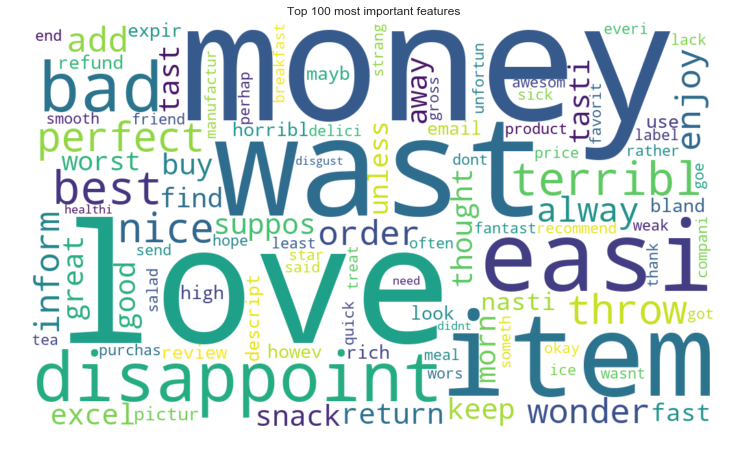

In [183]:
from wordcloud import WordCloud, STOPWORDS

features = tf_idf_vect.get_feature_names()
coef = clf.feature_importances_
coef_df = pd.DataFrame({'word': features, 'coeficient': coef}, index = None)
df = coef_df.sort_values("coeficient", ascending = False)[:100]
cloud = " ".join(word for word in df.word)
stopwords = set(STOPWORDS) 
wordcloud = WordCloud(width = 1000, height = 600, background_color ='white', stopwords = stopwords).generate(cloud) 
  
# plot the WordCloud image                        
plt.figure(figsize = (10, 8)) 
plt.imshow(wordcloud, interpolation = 'bilinear') 
plt.axis("off") 
plt.title("Top 100 most important features")
plt.tight_layout(pad = 0) 
  
plt.show() 

In [184]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[ 2764,  1339],
       [ 3850, 22047]], dtype=int64)

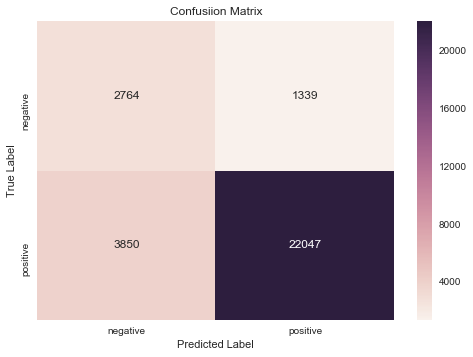

In [185]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [186]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.42      0.67      0.52      4103
           1       0.94      0.85      0.89     25897

   micro avg       0.83      0.83      0.83     30000
   macro avg       0.68      0.76      0.71     30000
weighted avg       0.87      0.83      0.84     30000



**Observations**
1. As in "random forest with bow" when max_depth and n_estimator is equal to 15 and 18 respectively, and in tfidf, it is also the same.
2. In the both representation of text, test accuracy is very similar.

# Word2vec

In [188]:
# data
X = final["Text"]
y = final["Score"]

In [192]:
# Split data
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, shuffle = False)
print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

(70000,) (30000,) (70000,) (30000,)


In [193]:
import re
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [194]:
# Train your own Word2Vec model using your own train text corpus
import gensim
list_of_sent=[]
#for sent in final_40k['Text'].values:
for sent in X_train:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [195]:
w2v_model_train = gensim.models.Word2Vec(list_of_sent, min_count = 5, size = 50, workers = 4)

In [196]:
w2v_model_train.wv.most_similar('like')

[('prefer', 0.6574416756629944),
 ('think', 0.6331843733787537),
 ('mean', 0.6148011684417725),
 ('crave', 0.5695065259933472),
 ('fine', 0.5640376806259155),
 ('overpower', 0.5629419088363647),
 ('enjoy', 0.5588371753692627),
 ('miss', 0.5584844946861267),
 ('know', 0.5542113780975342),
 ('love', 0.553889811038971)]

In [197]:
w2v_train = w2v_model_train[w2v_model_train.wv.vocab]

In [198]:
w2v_train.shape

(16156, 50)

In [199]:
# Train your own Word2Vec model using your own test text corpus
import gensim
list_of_sent_test = []
#for sent in final_40k['Text'].values:
for sent in x_test:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)

In [200]:
w2v_model_test = gensim.models.Word2Vec(list_of_sent_test, min_count = 5, size = 50, workers = 4)

In [201]:
w2v_model_test.wv.most_similar('like')

[('prefer', 0.6278116703033447),
 ('mean', 0.6077802181243896),
 ('think', 0.6008116602897644),
 ('enjoy', 0.5977833867073059),
 ('know', 0.5720909833908081),
 ('want', 0.5484650135040283),
 ('expect', 0.5377665162086487),
 ('miss', 0.5370445251464844),
 ('love', 0.5365544557571411),
 ('notice', 0.5350335836410522)]

In [202]:
w2v_test = w2v_model_test[w2v_model_test.wv.vocab]

In [203]:
w2v_test.shape

(10801, 50)

# Average word2vec

In [204]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

70000
50


In [205]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model_test.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

30000
50


In [206]:
X_train = np.array(sent_vectors)
#X_train

In [207]:
x_test = np.array(sent_vectors_test)
#x_test


**********GridSearchCV**********


Best depth: 9

Best estimator: 18

Best Score: 0.8492260894256017


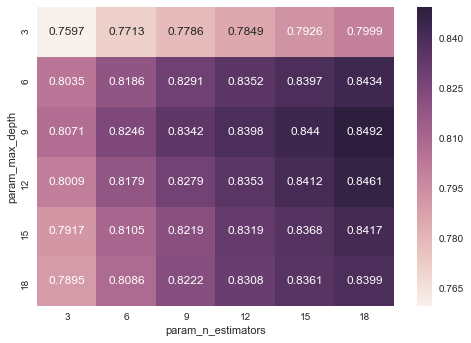

In [208]:
# XGBoost
optimal_max_depth_avgw2v, optimal_n_estimators_avgw2v = optimal_tree_xgb(X_train, y_train)

In [209]:
# instantiate learning model max_depth = mas_depth_tfidf
clf = XGBClassifier(max_depth = optimal_max_depth_avgw2v, n_estimators = optimal_n_estimators_avgw2v)
# fitting the model
clf.fit(X_train, y_train)
# predict the response
pred = clf.predict(x_test)
# predict probablistic response
pred_prob = clf.predict_proba(x_test)

In [210]:
train_acc_avgw2v = clf.score(X_train, y_train)
print("Train accuracy:", train_acc_avgw2v)

Train accuracy: 0.9267142857142857


In [211]:
test_acc_avgw2v_grid = roc_auc_score(y_test, pred_prob[:,1]) * 100
print('\nThe accuracy of the decision tree is %.2f%%' % (test_acc_avgw2v_grid))


The accuracy of the decision tree is 71.43%


In [212]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[  151,  3952],
       [  168, 25729]], dtype=int64)

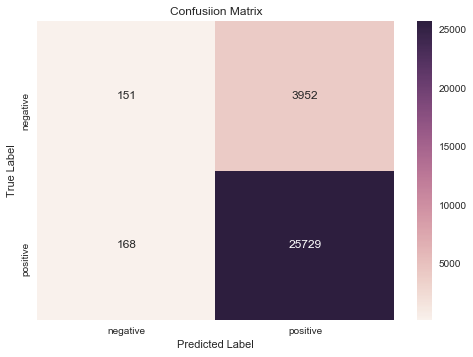

In [213]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [214]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.47      0.04      0.07      4103
           1       0.87      0.99      0.93     25897

   micro avg       0.86      0.86      0.86     30000
   macro avg       0.67      0.52      0.50     30000
weighted avg       0.81      0.86      0.81     30000



**Observations**<br>
1. It did not work well on test data. I.e. generalization error is high.
2. This model may overfit as the test error is higer than train error.


**********GridSearchCV**********


Best depth: 9

Best estimator: 18

Best Score: 0.8404515605193011


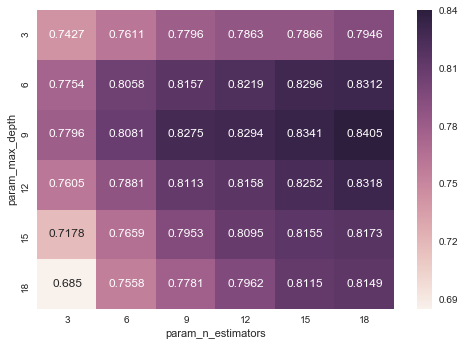

In [215]:
# Random Forest
optimal_max_depth_avgw2v_rf, optimal_n_estimators_avgw2v_rf = optimal_tree_rf(X_train, y_train)

In [216]:
# instantiate learning model max_depth = max_depth_bow
clf = RandomForestClassifier(max_depth = optimal_max_depth_avgw2v_rf, n_estimators = optimal_n_estimators_avgw2v_rf, class_weight = "balanced")
# fitting the model
clf.fit(X_train, y_train)
# predict the response
pred = clf.predict(x_test)
# predict probablistic response
pred_prob = clf.predict_proba(x_test)

In [217]:
train_acc_avgw2v_rf = clf.score(X_train, y_train)
print("Train accuracy %f%%:" % (train_acc_avgw2v_rf))

Train accuracy 0.841586%:


In [218]:
test_acc_avgw2v_rf = roc_auc_score(y_test, pred_prob[:,1]) * 100
print('\nThe test accuracy is %.2f%%' % (test_acc_avgw2v_rf))


The test accuracy is 73.87%


In [219]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[ 1214,  2889],
       [ 2149, 23748]], dtype=int64)

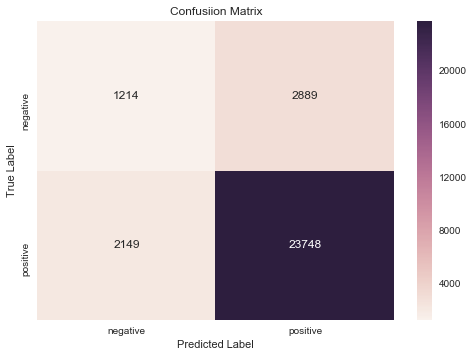

In [220]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [221]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.36      0.30      0.33      4103
           1       0.89      0.92      0.90     25897

   micro avg       0.83      0.83      0.83     30000
   macro avg       0.63      0.61      0.61     30000
weighted avg       0.82      0.83      0.82     30000



**Observations**
1. As we can see the max_depth and n_esimator is 9 and 18 model works better.
2. Even though the dimention is very low, it doesn't work well. 

# TFIDF Word2Vec

In [222]:
import pickle
fp = open("tfidf_w2v_train", "rb")
X_train = pickle.load(fp)
fp.close()

In [223]:
fp = open("tfidf_w2v_test", "rb")
x_test = pickle.load(fp)
fp.close()

In [225]:
X_train = np.array(X_train)
x_test = np.array(x_test)


**********GridSearchCV**********


Best depth: 9

Best estimator: 18

Best Score: 0.7762209948783283


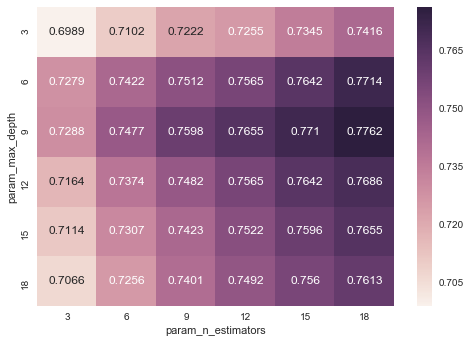

In [226]:
# XGBoost
optimal_max_depth_tfidfw2v, optimal_n_estimators_tfidfw2v = optimal_tree_xgb(X_train, y_train)

In [227]:
# instantiate learning model max_depth = mas_depth_tfidf
clf = XGBClassifier(max_depth = optimal_max_depth_tfidfw2v, n_estimators = optimal_n_estimators_tfidfw2v)
# fitting the model
clf.fit(X_train, y_train)
# predict the response
pred = clf.predict(x_test)
# predict probablistic response
pred_prob = clf.predict_proba(x_test)

In [232]:
# Accuracy on train data
train_acc_tfidfw2v = clf.score(X_train, y_train)
print("Train accuracy", train_acc_tfidfw2v)

Train accuracy 0.9050285714285714


In [239]:
test_acc_tfidfw2v = roc_auc_score(y_test, pred_prob[:,1]) * 100
print('\nThe accuracy of the desicion tree is %f%%' % (test_acc_tfidfw2v))


The accuracy of the desicion tree is 65.709647%


In [234]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[   58,  4045],
       [  149, 25748]], dtype=int64)

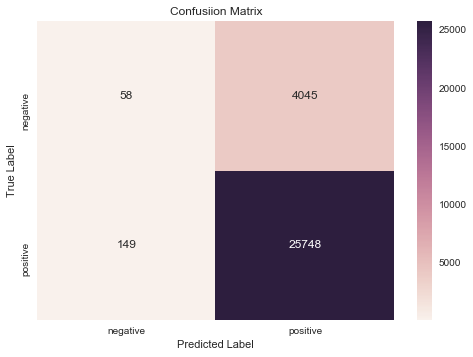

In [235]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [236]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.28      0.01      0.03      4103
           1       0.86      0.99      0.92     25897

   micro avg       0.86      0.86      0.86     30000
   macro avg       0.57      0.50      0.48     30000
weighted avg       0.78      0.86      0.80     30000



**Observations**<br>
1. The roc_auc score is very poor. I.e. Generalization error is high. 
2. It is clearly seen that in heatmap, what is the best socre on which hyperparameter value.

In [241]:
X_train = np.nan_to_num(X_train)
x_test = np.nan_to_num(x_test)


**********GridSearchCV**********


Best depth: 9

Best estimator: 18

Best Score: 0.7635417433048326


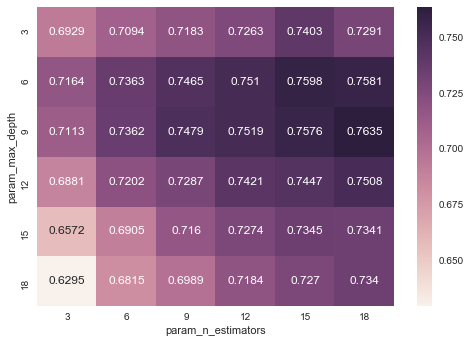

In [242]:
# Random Forest
optimal_max_depth_tfidfw2v_rf, optimal_n_estimators_tfidfw2v_rf = optimal_tree_rf(X_train, y_train)

In [243]:
# instantiate learning model max_depth = max_depth_bow
clf = RandomForestClassifier(max_depth = optimal_max_depth_tfidfw2v_rf, n_estimators = optimal_n_estimators_tfidfw2v_rf, class_weight = "balanced")
# fitting the model
clf.fit(X_train, y_train)
# predict the response
pred = clf.predict(x_test)
# predict probablistic response
pred_prob = clf.predict_proba(x_test)

In [244]:
train_acc_tfidfw2v_rf = clf.score(X_train, y_train)
print("Train accuracy %f%%:" % (train_acc_tfidfw2v_rf))

Train accuracy 0.816371%:


In [245]:
test_acc_tfidfw2v_rf = roc_auc_score(y_test, pred_prob[:,1]) * 100
print('\nThe test accuracy is %.2f%%' % (test_acc_tfidfw2v_rf))


The test accuracy is 67.96%


In [246]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[ 2017,  2086],
       [ 6577, 19320]], dtype=int64)

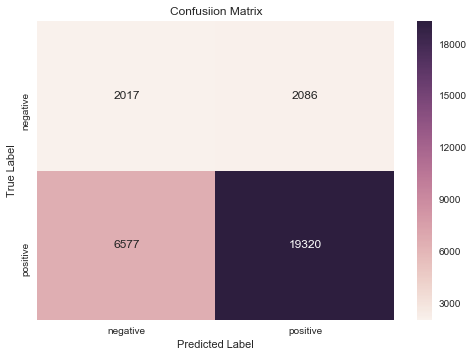

In [247]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [248]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.23      0.49      0.32      4103
           1       0.90      0.75      0.82     25897

   micro avg       0.71      0.71      0.71     30000
   macro avg       0.57      0.62      0.57     30000
weighted avg       0.81      0.71      0.75     30000



**Observations** <br>
1. This model slightly better than the previous one but did not generalize well. I.e. poor performence on test data.

**Conclusions**<br>
1. For each text representation, we tuned hyperparameter(max_depth and n_estimator) and calculated score for XGBOOSt and RF.<br>
2. Random forest works well on bow and tfidf representations of text. Whereas, xgboost fails to perform better in all the four vectorization.<br>
3. RF & XGBOOST have many parameters to tune but we work on only 2 parameter here, as we wanted to show it in heatmap.<br>
4. We printed feature importance in a word cloud, so that it is easy to clearly identify in a single shot, which feature is most important.<br>
5. We calculated roc_auc score because data was imbalanced and it works better than accuracy, in this situation.<br>

In [270]:
# model performence table
# XGBoost
import itable
models = pd.DataFrame({'Model': ['XGB with Bow', "XGB with TFIDF", "XGB with avgw2v", "XGB with TFIDFW2V"], 'Hyper Parameter(max_depth)': [optimal_max_depth_bow, optimal_max_depth_tfidf, optimal_max_depth_avgw2v, optimal_max_depth_tfidfw2v ], 'Hyper parameter(n_estimators)': [optimal_n_estimators_bow, optimal_n_estimators_tfidf, optimal_n_estimators_avgw2v, optimal_n_estimators_tfidfw2v], 'Train Error': [1-train_acc_bow, 1-train_acc_tfidf, 1-train_acc_avgw2v, 1-train_acc_tfidfw2v], 'Test Error': [100-test_acc_bow, 100-test_acc_tfidf, 100-test_acc_avgw2v_grid, 100-test_acc_tfidfw2v], 'Auc Score': [test_acc_bow, test_acc_tfidf, test_acc_avgw2v_grid, test_acc_tfidfw2v]}, columns = ["Model", "Hyper Parameter(max_depth)", "Hyper parameter(n_estimators)", "Train Error", "Test Error", "Auc Score"]).sort_values(by = 'Auc Score', ascending=False)
itable.PrettyTable(models, tstyle=itable.TableStyle(theme = "theme1"), center = True, header_row = True)

,Model,Hyper Parameter(max_depth),Hyper parameter(n_estimators),Train Error,Test Error,Auc Score
1,XGB with TFIDF,18,18,0.07538571428571428,13.994943560087208,86.00505643991279
0,XGB with Bow,18,18,0.07909999999999995,14.699183968413394,85.3008160315866
2,XGB with avgw2v,9,18,0.07328571428571429,28.56795614257352,71.43204385742648
3,XGB with TFIDFW2V,9,18,0.0949714285714286,34.29035332428451,65.70964667571549


In [273]:
# model performence table
# RandomForest
import itable
models = pd.DataFrame({'Model': ['RF with Bow', "RF with TFIDF", "RF with avgw2v", "RF with TFIDFW2V"], 'Hyper Parameter(max_depth)': [optimal_max_depth_bow_rf, optimal_max_depth_tfidf_rf, optimal_max_depth_avgw2v_rf, optimal_max_depth_tfidfw2v_rf ],'Hyper Parameter(n_estimators)': [optimal_max_depth_bow_rf, optimal_max_depth_tfidf_rf, optimal_max_depth_avgw2v_rf, optimal_max_depth_tfidfw2v_rf], 'Train Error': [1-train_acc_bow_rf, 1-train_acc_tfidf_rf, 1-train_acc_avgw2v_rf, 1-train_acc_tfidfw2v_rf], 'Test Error': [100-test_acc_bow_rf, 100-test_acc_tfidf_rf, 100-test_acc_avgw2v_rf, 100-test_acc_tfidfw2v_rf], 'Auc Score': [test_acc_bow_rf, test_acc_tfidf_rf, test_acc_avgw2v_rf, test_acc_tfidfw2v_rf]}, columns = ["Model", "Hyper Parameter(max_depth)", "Hyper Parameter(n_estimators)", "Train Error", "Test Error", "Auc Score"]).sort_values(by = 'Auc Score', ascending=False)
itable.PrettyTable(models, tstyle=itable.TableStyle(theme = "theme1"), center = True, header_row = True)

,Model,Hyper Parameter(max_depth),Hyper Parameter(n_estimators),Train Error,Test Error,Auc Score
0,RF with Bow,15,15,0.13977142857142855,14.027430784463789,85.97256921553621
1,RF with TFIDF,15,15,0.13780000000000003,14.800715382055301,85.1992846179447
2,RF with avgw2v,9,9,0.15841428571428573,26.132061384066617,73.86793861593338
3,RF with TFIDFW2V,9,9,0.18362857142857147,32.041550249436284,67.95844975056372
